
# Closed–Lost Deal Analysis (High‑Intent Deals)

This notebook reproduces the analysis you saw in chat:
1. **Load & filter** to deals with both *Annual Construction Volume* and *ARR* (signed quote but turned down).
2. **Feature engineering** (numeric/date parsing, sales-cycle calc).
3. **Text clustering** of `Closed Lost Reason` using TF‑IDF + KMeans.
4. **Statistical profile** by cluster (deal count, ARR loss, ACV, cycle).
5. **Visualization**: ARR loss vs. sales cycle (bubble plot).
6. **Insights & remediation plan** mapped to clusters.

> **Note:** Update `file_path` below if you move/rename the CSV.


In [11]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Display options
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
file_path = "/content/drive/MyDrive/Copy of Churn Analysis FY'23 - FY'25 - Raw Data - Closed Lost YTD.csv" # Replace with your actual path

try:
    df = pd.read_csv(file_path)
    print(f"Loaded shape: {df.shape}")
    display(df.head(3))
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path to your file in Google Drive.")

Loaded shape: (84, 16)


,Record ID,Deal Name,Deal Stage,Close Date,Churn Date,Deal owner,Annual Construction Volume,Amount,ARR,ACV/ARR,Latest Demo Date,Sales Rep,Demo Status,Demo Completed,Pipeline,Closed Lost Reason
0,36601034676,Great Yarmouth Ceilings,Closed - Lost,2025-05-30 7:35,NaN,Joshua Burmeister,"10,000,000.00","8,000",NaN,NaN,2025-05-06,Joshua Burmeister,NaN,Yes,Outbuild Sales,"non-ICP, subcontractor"
1,36124361884,JH Cleveland Construction,Closed - Lost,2025-05-30 8:14,NaN,Joshua Burmeister,"25,000,000.00","12,000",NaN,NaN,2025-05-02,Oscar Garcia,NaN,Yes,Outbuild Sales,"combo of price and timing, get president on ca..."
2,35837660944,Holt Logistics,Closed - Lost,2025-04-29 7:25,NaN,Joshua Burmeister,NaN,NaN,NaN,NaN,2025-04-17,NaN,NaN,NaN,Outbuild Sales,No fit


In [14]:
## Set the path to your CSV
#file_path = "Churn Analysis FY'23 - FY'25 - Raw Data - Closed Lost YTD.csv"

# Load
#df = pd.read_csv(file_path)
#print(f"Loaded shape: {df.shape}")
#display(df.head(3))

## Filter to signed-quote (ACV & ARR present)

In [15]:

df_filtered = df.dropna(subset=["Annual Construction Volume", "ARR"]).copy().reset_index(drop=True)

# Convert numeric string columns (remove commas) and dates
for col in ["Amount", "ARR", "ACV/ARR"]:
    df_filtered[col] = df_filtered[col].replace({",": ""}, regex=True).astype(float)

df_filtered["Close Date"] = pd.to_datetime(df_filtered["Close Date"], errors="coerce")
df_filtered["Latest Demo Date"] = pd.to_datetime(df_filtered["Latest Demo Date"], errors="coerce")
df_filtered["Sales_Cycle_days"] = (df_filtered["Close Date"] - df_filtered["Latest Demo Date"]).dt.days

print("Filtered deals:", len(df_filtered))
df_filtered.head(5)


Filtered deals: 51


,Record ID,Deal Name,Deal Stage,Close Date,Churn Date,Deal owner,Annual Construction Volume,Amount,ARR,ACV/ARR,Latest Demo Date,Sales Rep,Demo Status,Demo Completed,Pipeline,Closed Lost Reason,Sales_Cycle_days
0,35627954458,Whaley Construction,Closed - Lost,2025-05-15 07:42:00,NaN,Collin Creach,"61,000,000.00","57,000.00","19,000.00","3,211.00",2025-04-16,Daniel DiGiovanni,NaN,Yes,Outbuild Sales,"did workshop but only with PM's, they were res...",29.00
1,35073539161,Palace Construction,Closed - Lost,2025-06-05 11:27:00,NaN,Yasamin Sean,"85,000,000.00","72,294.00","24,098.00","3,527.00",2025-03-25,Milena Christoff,NaN,Yes,Outbuild Sales,Postponed due to internal priorities. Revisit ...,72.00
2,34823743574,Wasatch West Contracting,Closed - Lost,2025-04-18 08:49:00,NaN,Daniel DiGiovanni,"8,550,000.00","12,655.00","4,218.00","2,027.00",2025-03-26,Milena Christoff,NaN,Yes,Outbuild Sales,"Loved the product, whole team sees value, but ...",23.00
3,34798363251,Rouse Homes Inc,Closed - Lost,2025-03-25 12:24:00,NaN,Daniel DiGiovanni,"5,500,000.00","8,505.00","2,835.00","1,940.00",2025-03-19,Daniel DiGiovanni,NaN,Yes,Outbuild Sales,"Went with JobTread, wanted to track P&L's (whi...",6.00
4,34793289569,Taylor International,Closed - Lost,2025-05-23 15:35:00,NaN,Yasamin Sean,"60,000,000.00","56,700.00","18,900.00","3,175.00",2025-04-08,Milena Christoff,NaN,Yes,Outbuild Sales,Recently renewed their P6 licenses in February...,45.00


## Statistical Profile

In [16]:

stats_summary = {
    "Total Deals": len(df_filtered),
    "Total ARR Lost": df_filtered["ARR"].sum(),
    "Median ARR": df_filtered["ARR"].median(),
    "ARR Range": (df_filtered["ARR"].min(), df_filtered["ARR"].max()),
    "Median ACV/ARR Ratio": df_filtered["ACV/ARR"].median(),
    "Annual Construction Volume Range": (df_filtered["Annual Construction Volume"].min(), df_filtered["Annual Construction Volume"].max()),
    "Deals with Demo Completed": (df_filtered["Demo Completed"].str.lower() == "yes").sum(),
    "Median Sales Cycle (days)": df_filtered["Sales_Cycle_days"].median()
}
stats_summary


{'Total Deals': 51,
 'Total ARR Lost': np.float64(1211900.0),
 'Median ARR': 19000.0,
 'ARR Range': (2835.0, 92000.0),
 'Median ACV/ARR Ratio': 3211.0,
 'Annual Construction Volume Range': (5500000.0, 500000000.0),
 'Deals with Demo Completed': np.int64(49),
 'Median Sales Cycle (days)': 84.0}

In [17]:

# Top raw loss reasons (quick glance)
df_filtered["Closed Lost Reason"].str.strip().str.lower().value_counts().head(15)


,count
Closed Lost Reason,
"did workshop but only with pm's, they were resistant to bring in supers for testing. they wanted to replace p6 with something more simple and ended up going with ms project - said it works well enough for what they need and is 25% of the cost. definitely were missing the full picture in value by not bringing in the field",1
postponed due to internal priorities. revisit in 2026.,1
"loved the product, whole team sees value, but onboarding other software right now and timing isn't right.",1
"went with jobtread, wanted to track p&l's (which is more of a pm tool thing)",1
recently renewed their p6 licenses in february and couldn't justify overlapping costs. shaun said to reconnect in q4 and keep him in the loop with webinars/ etc,1
andy (who was hired between our deep dive and map) did in fact get this deal thrown out the window. andy is brining on a number of new pm's that he formally worked with and jonathan said that with the exponential growth they are having they don't want to rock the boat too much with new hires that andy is brining on so they are going to use phoenix instead b/c that is what andy wants. notes from the conversation in the notes,1
karl did not champion change. the final question was: do i want to have my team change how we currently schedule and that answer turned out to be no,1
"budget issues, job costing too much tech -- in the past couple weeks with these new tariffs, a few big jobs pushed, they may be looking at lay offs. they want to revisit once they're more stable",1
said they are too busy to move to a new software and will reach out if and when they are ready,1


## Cluster `Closed Lost Reason` text

In [18]:

reasons = df_filtered["Closed Lost Reason"].fillna("").str.lower()

# TF-IDF + KMeans
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(reasons)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

df_filtered["Loss Cluster"] = clusters

# Top keywords per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
cluster_keywords = {i: [terms[ind] for ind in order_centroids[i, :8]] for i in range(5)}

cluster_keywords


{0: ['project',
  'couldn',
  'said',
  'ms',
  'outbuild',
  'pm',
  'started',
  'workshop'],
 1: ['going',
  'deal',
  'closing',
  'months',
  'priorities',
  'katrina',
  'champion',
  'q3'],
 2: ['price',
  'need',
  'process',
  'current',
  'shut',
  'failed',
  'problem',
  'reporting'],
 3: ['change',
  'team',
  'schedule',
  'project',
  'moving',
  'able',
  'field',
  'forward'],
 4: ['jobs', 'new', 'software', 'right', 'andy', 'reach', 'sees', 'busy']}

In [19]:

# Cluster stats table
cluster_stats = (
    df_filtered
    .groupby("Loss Cluster")
    .agg(
        Deals=("Record ID", "count"),
        Total_ARR=("ARR", "sum"),
        Median_ARR=("ARR", "median"),
        Median_ACV=("Annual Construction Volume", "median"),
        Median_Sales_Cycle_days=("Sales_Cycle_days", "median"),
    )
    .reset_index()
)
cluster_stats


,Loss Cluster,Deals,Total_ARR,Median_ARR,Median_ACV,Median_Sales_Cycle_days
0,0,13,"263,286.00","19,000.00","61,000,000.00",60.00
1,1,12,"281,501.00","18,850.00","55,000,000.00",106.50
2,2,9,"250,971.00","13,000.00","25,000,000.00",73.00
3,3,9,"243,598.00","26,000.00","100,000,000.00",135.00
4,4,8,"172,544.00","14,560.00","37,500,000.00",81.50


## Visualization — ARR Loss vs. Median Sales Cycle (by Cluster)

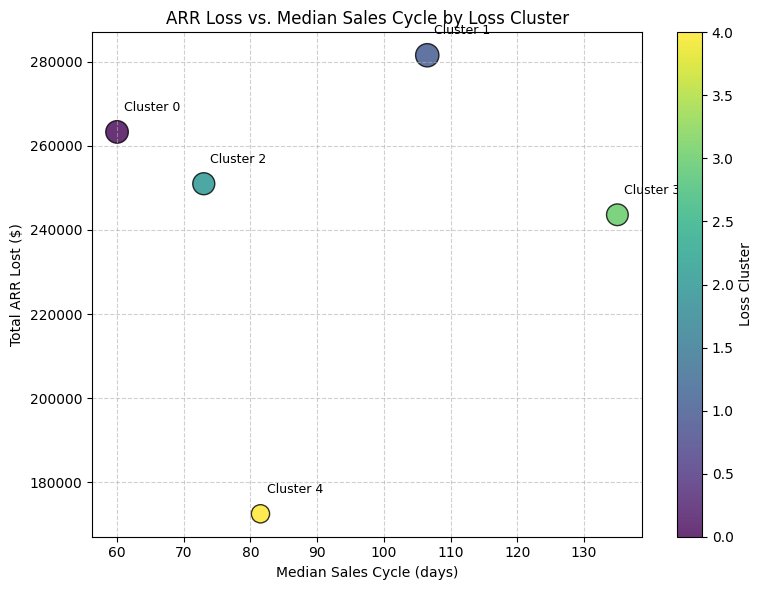

In [20]:

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    cluster_stats["Median_Sales_Cycle_days"],
    cluster_stats["Total_ARR"],
    c=cluster_stats["Loss Cluster"],
    s=cluster_stats["Total_ARR"] / 1000,  # bubble size scaled by ARR
    alpha=0.8,
    edgecolors="k"
)

for _, row in cluster_stats.iterrows():
    plt.text(row["Median_Sales_Cycle_days"] + 1,
             row["Total_ARR"] + 5000,
             f"Cluster {int(row['Loss Cluster'])}", fontsize=9)

plt.title("ARR Loss vs. Median Sales Cycle by Loss Cluster")
plt.xlabel("Median Sales Cycle (days)")
plt.ylabel("Total ARR Lost ($)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.colorbar(scatter, label="Loss Cluster")
plt.tight_layout()
plt.show()


## Insights by Cluster

In [21]:

def describe_cluster(row, keywords):
    cid = int(row["Loss Cluster"])
    deals = int(row["Deals"])
    total_arr = row["Total_ARR"]
    median_arr = row["Median_ARR"]
    median_acv = row["Median_ACV"]
    sales_cycle = row["Median_Sales_Cycle_days"]
    words = ", ".join(keywords[cid][:5])

    theme_map = {
        0: "Timing / future jobs",
        1: "Priorities stalled (champion weakened)",
        2: "Process / pricing (workshop fit, pricing pushback)",
        3: "Executive rejection (killed at top)",
        4: "Competition (P6 / MS Project)"
    }
    theme = theme_map.get(cid, "Unlabeled")

    return (
        f"**Cluster {cid} – {theme}**\n"
        f"- Deals: {deals}, Total ARR lost: ${total_arr:,.0f}\n"
        f"- Median ARR: ${median_arr:,.0f}, Median ACV: ${median_acv:,.0f}\n"
        f"- Median Sales Cycle: {sales_cycle} days\n"
        f"- Top keywords: {words}"
    )

for _, r in cluster_stats.iterrows():
    print(describe_cluster(r, cluster_keywords) + "\n")


**Cluster 0 – Timing / future jobs**
- Deals: 13, Total ARR lost: $263,286
- Median ARR: $19,000, Median ACV: $61,000,000
- Median Sales Cycle: 60.0 days
- Top keywords: project, couldn, said, ms, outbuild

**Cluster 1 – Priorities stalled (champion weakened)**
- Deals: 12, Total ARR lost: $281,501
- Median ARR: $18,850, Median ACV: $55,000,000
- Median Sales Cycle: 106.5 days
- Top keywords: going, deal, closing, months, priorities

**Cluster 2 – Process / pricing (workshop fit, pricing pushback)**
- Deals: 9, Total ARR lost: $250,971
- Median ARR: $13,000, Median ACV: $25,000,000
- Median Sales Cycle: 73.0 days
- Top keywords: price, need, process, current, shut

**Cluster 3 – Executive rejection (killed at top)**
- Deals: 9, Total ARR lost: $243,598
- Median ARR: $26,000, Median ACV: $100,000,000
- Median Sales Cycle: 135.0 days
- Top keywords: change, team, schedule, project, moving

**Cluster 4 – Competition (P6 / MS Project)**
- Deals: 8, Total ARR lost: $172,544
- Median ARR: $1

## Remediation Plan (by Cluster)

In [22]:

remedies = {
0: [
    "Tag with expected project start; auto re-engage 60–90 days prior.",
    "Light nurture: case studies and feature updates during downtime.",
    "Offer pre-contract incentive to lock pricing ahead of project start."
],
1: [
    "Enforce early multi-threading: ≥2 exec sponsors before Stage 2 exit.",
    "If no exec alignment by day 45, downgrade forecast or pause pursuit.",
    "Run 'Priority Reset' exec meeting tied to board-level outcomes."
],
2: [
    "Redesign workshops around 2–3 measurable ROI levers (not feature tours).",
    "Modular pricing (land small, expand) to reduce initial barrier.",
    "Pricing objection library tied to construction volume economics."
],
3: [
    "Insert exec sponsor discovery call *before* workshop.",
    "Provide financial models quantifying cost of delay & inefficiency.",
    "Involve SE/VP Sales early for ACV > $60M to build C‑suite credibility."
],
4: [
    "Displacement messaging vs. P6/MS Project: TCO, implementation speed, field adoption.",
    "Competitive battlecards and reference stories of replacements.",
    "Targeted SPIFFs for wins vs. incumbents."
]
}

for cid, items in remedies.items():
    print(f"Cluster {cid}:")
    for i, item in enumerate(items, 1):
        print(f"  {i}. {item}")
    print()


Cluster 0:
  1. Tag with expected project start; auto re-engage 60–90 days prior.
  2. Light nurture: case studies and feature updates during downtime.
  3. Offer pre-contract incentive to lock pricing ahead of project start.

Cluster 1:
  1. Enforce early multi-threading: ≥2 exec sponsors before Stage 2 exit.
  2. If no exec alignment by day 45, downgrade forecast or pause pursuit.
  3. Run 'Priority Reset' exec meeting tied to board-level outcomes.

Cluster 2:
  1. Redesign workshops around 2–3 measurable ROI levers (not feature tours).
  2. Modular pricing (land small, expand) to reduce initial barrier.
  3. Pricing objection library tied to construction volume economics.

Cluster 3:
  1. Insert exec sponsor discovery call *before* workshop.
  2. Provide financial models quantifying cost of delay & inefficiency.
  3. Involve SE/VP Sales early for ACV > $60M to build C‑suite credibility.

Cluster 4:
  1. Displacement messaging vs. P6/MS Project: TCO, implementation speed, field adopt

After running the cell above and following the prompts to authorize Google Drive access, you can load your CSV file. Replace `'Path/to/your/file.csv'` with the actual path to your file in Google Drive.